2025-05-12 09:53:23.160689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747043603.403205      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747043603.472388      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Image dataset already unzipped.
Using device: cuda
Loading BLIP-2 base model...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

BLIP-2 model loaded successfully
Starting BLIP-2 baseline evaluation...
Loading dataset from /kaggle/input/vqa-dataset/vqa_dataset_gemini_final.csv
Dataset loaded with 19497 samples
Columns: ['path', 'generated_question', 'generated_answer']

Processing sample size: 3000


100%|██████████| 3000/3000 [18:30<00:00,  2.70it/s]



Skipped question stats for sample size 3000:
  image_only: 0
  answer_only: 0
  identical: 0
  too_short: 0
  valid: 3000

Results for sample size 3000:
exact_match_accuracy: 0.0000
relaxed_accuracy: 0.1087
word_overlap: 0.0697
Time taken: 1110.31 seconds

Processing sample size: 7000


100%|██████████| 7000/7000 [42:50<00:00,  2.72it/s]



Skipped question stats for sample size 7000:
  image_only: 0
  answer_only: 0
  identical: 0
  too_short: 0
  valid: 7000

Results for sample size 7000:
exact_match_accuracy: 0.0000
relaxed_accuracy: 0.1086
word_overlap: 0.0720
Time taken: 2570.90 seconds
Metrics plot saved.
Evaluation complete.


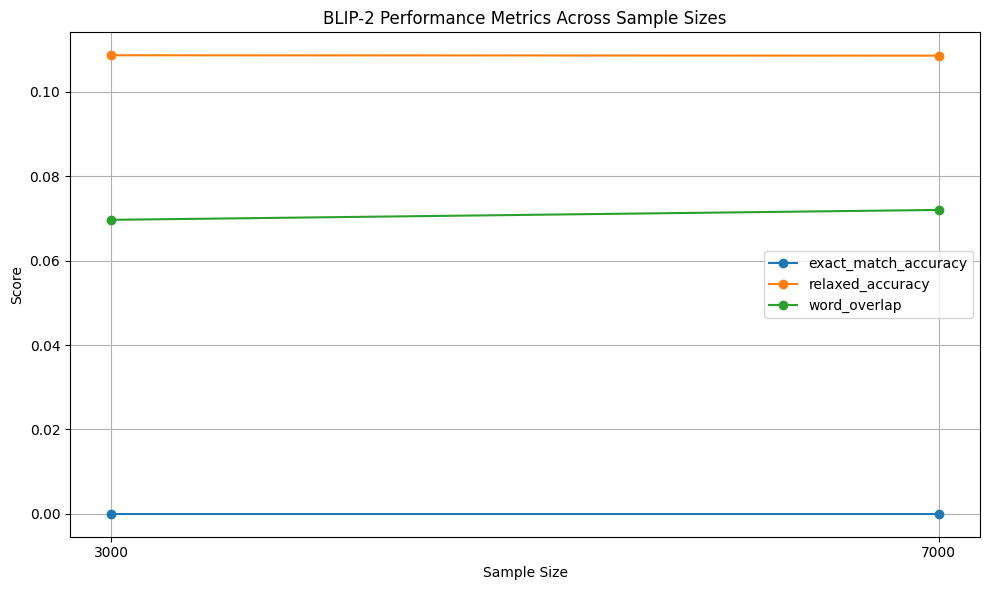

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from sklearn.metrics import accuracy_score, f1_score
import zipfile

zip_path = "/kaggle/input/vqa-dataset/req-images.zip"
unzip_path = "/kaggle/input/vqa-dataset/req-images"
if not os.path.exists(unzip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("/kaggle/working/results", exist_ok=True)

import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

model_name = "Salesforce/blip2-opt-2.7b"
processor = Blip2Processor.from_pretrained(model_name)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

def load_kaggle_vqa_dataset():
    csv_path = "/kaggle/input/vqa-dataset/vqa_dataset_gemini_final.csv"
    df = pd.read_csv(csv_path)
    return df

def run_inference(image_path, question):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, text=question, return_tensors="pt").to(device, torch.float16)
        with torch.no_grad():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=10,
                num_beams=5,
                do_sample=False
            )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return generated_text
    except Exception as e:
        print(f"Error during inference for image {image_path}: {e}")
        return ""

def evaluate_predictions(predictions, ground_truths):
    exact_matches = [pred.lower() == gt.lower() for pred, gt in zip(predictions, ground_truths)]
    relaxed_matches = [gt.lower() in pred.lower() or pred.lower() in gt.lower()
                       for pred, gt in zip(predictions, ground_truths)]

    def word_overlap_score(pred, gt):
        if not pred or not gt:
            return 0.0
        pred_words = set(pred.lower().split())
        gt_words = set(gt.lower().split())
        return len(pred_words.intersection(gt_words)) / len(gt_words)

    word_overlap_scores = [word_overlap_score(pred, gt) for pred, gt in zip(predictions, ground_truths)]

    metrics = {
        "exact_match_accuracy": sum(exact_matches) / len(exact_matches),
        "relaxed_accuracy": sum(relaxed_matches) / len(relaxed_matches),
        "word_overlap": sum(word_overlap_scores) / len(word_overlap_scores)
    }
    return metrics

def run_progressive_baseline_evaluation(sample_sizes=[3000, 7000, 10000, 'full']):
    full_df = load_kaggle_vqa_dataset()
    total_size = len(full_df)
    actual_sample_sizes = [total_size if s == 'full' else min(int(s), total_size) for s in sample_sizes]

    all_metrics = {}
    all_sample_times = {}
    cumulative_results = []

    for sample_size in actual_sample_sizes:
        sample_name = str(sample_size) if sample_size != total_size else 'full'
        start_time = time.time()

        df_sample = full_df.sample(sample_size, random_state=42) if sample_size < total_size else full_df

        predictions, ground_truths, image_ids, questions = [], [], [], []
        skipped_stats = {"image_only": 0, "answer_only": 0, "identical": 0, "too_short": 0, "valid": 0}

        for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
            image_path = row['path']
            question = str(row['generated_question']).strip()
            answer = str(row['generated_answer']).strip()

            if not isinstance(question, str) or not question:
                skipped_stats["image_only"] += 1
                continue
            if not isinstance(answer, str) or not answer:
                skipped_stats["answer_only"] += 1
                continue
            if question.lower() == answer.lower():
                skipped_stats["identical"] += 1
                continue
            if len(question.split()) < 2 and len(answer.split()) < 2:
                skipped_stats["too_short"] += 1
                continue

            if not image_path.startswith("/kaggle"):
                image_path = os.path.join("/kaggle/input/vqa-dataset/req-images/req-images/", image_path)

            prediction = run_inference(image_path, question)
            predictions.append(prediction)
            ground_truths.append(answer)
            image_ids.append(os.path.basename(image_path))
            questions.append(question)
            skipped_stats["valid"] += 1

        metrics = evaluate_predictions(predictions, ground_truths)
        all_metrics[sample_size] = metrics
        elapsed_time = time.time() - start_time
        all_sample_times[sample_size] = elapsed_time

        results_df = pd.DataFrame({
            'image_id': image_ids,
            'question': questions,
            'ground_truth': ground_truths,
            'prediction': predictions,
            'sample_size': sample_name
        })
        results_df.to_csv(f"/kaggle/working/results/blip2_baseline_results_{sample_name}.csv", index=False)
        cumulative_results.append(results_df)

    final_results = pd.concat(cumulative_results, ignore_index=True)
    final_results.to_csv("/kaggle/working/results/blip2_baseline_all_results.csv", index=False)

    metrics_df = pd.DataFrame([all_metrics[s] for s in actual_sample_sizes],
                              index=[str(s) for s in actual_sample_sizes])
    metrics_df["sample_size"] = [str(s) for s in actual_sample_sizes]
    metrics_df["time_seconds"] = [all_sample_times[s] for s in actual_sample_sizes]
    metrics_df.to_csv("/kaggle/working/results/blip2_baseline_all_metrics.csv", index=False)

    plot_metrics(all_metrics, actual_sample_sizes)
    return all_metrics, final_results

def plot_metrics(all_metrics, sample_sizes):
    plt.figure(figsize=(10, 6))
    x = [str(s) for s in sample_sizes]
    for key in all_metrics[sample_sizes[0]].keys():
        y = [all_metrics[s][key] for s in sample_sizes]
        plt.plot(x, y, marker='o', label=key)
    plt.xlabel("Sample Size")
    plt.ylabel("Score")
    plt.title("BLIP-2 Performance Metrics Across Sample Sizes")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("/kaggle/working/results/blip2_metrics_by_sample_size.png")

if __name__ == "__main__":
    sample_sizes = [3000, 7000]
    run_progressive_baseline_evaluation(sample_sizes)
